# Subtask 1: Text Analysis
## Identify Persuasion Techniques in Textual Context Only

### Load and Preproccess the Data

In [1]:
import pandas as pd
import json
import re
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import resample
from transformers import RobertaTokenizer
import torch
from torch.utils.data import DataLoader, Dataset
import spacy
from contractions import fix

In [2]:
# Utility Functions
def load_data(file_path):
    """Load JSON data from file and return as DataFrame."""
    with open(file_path, 'r') as file:
        data = json.load(file)
    return pd.DataFrame(data)

def clean_text(text):
    """Remove URLs, mentions, special characters, and normalize whitespace and case."""
    text = text.replace("\n", " ")
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

def process_dataset(dataset, mlb):
    """Process dataset by cleaning text, balancing labels, and encoding labels."""
    dataset['cleaned_text'] = dataset['text'].apply(clean_text)
    dataset = dataset[dataset['labels'].apply(len) > 0]
    dataset = balance_labels(dataset, 'labels')
    dataset['encoded_labels'] = mlb.fit_transform(dataset['labels']).tolist()
    return dataset

def balance_labels(df, label_column):
    """Balance the dataset by oversampling labels that appear less than 300 times."""
    all_labels = [label for labels in df[label_column] for label in labels]
    label_counts = pd.Series(all_labels).value_counts()
    rare_labels = label_counts[label_counts < 300].index.tolist()
    oversampled_data = [resample(df[df[label_column].apply(lambda x: label in x)],
                                 replace=True, n_samples=300, random_state=42)
                        for label in rare_labels]
    return pd.concat([df] + oversampled_data).sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
# Load datasets
train_file_path = 'train.json'
validation_file_path = 'validation.json'
train_data = load_data(train_file_path)
validation_data = load_data(validation_file_path)

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Process both datasets
train_data = process_dataset(train_data, mlb)
validation_data = process_dataset(validation_data, mlb)

# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize text for both datasets
train_encodings = tokenizer(train_data['cleaned_text'].tolist(), truncation=True, padding="max_length", max_length=128, return_tensors="pt")
validation_encodings = tokenizer(validation_data['cleaned_text'].tolist(), truncation=True, padding="max_length", max_length=128, return_tensors="pt")

# Define MultilabelDataset class
class MultilabelDataset(Dataset):
    """Custom dataset for handling multilabel data."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# Create datasets
train_dataset = MultilabelDataset(train_encodings, train_data['encoded_labels'])
validation_dataset = MultilabelDataset(validation_encodings, validation_data['encoded_labels'])


print(f"Training Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(validation_dataset)}")
print(f"Sample Original Text from Training: {train_data['text'].iloc[:5]}")
print(f"Sample Cleaned Text from Training: {train_data['cleaned_text'].iloc[:5]}")
print(f"Sample Encoded Labels from Training: {train_data['encoded_labels'][:5]}")


Training Dataset Length: 7836
Validation Dataset Length: 6412
Sample Original Text from Training: 0                             FREE RAMAN PRATASEVICH\n
1    \ALL WE NEED IS THE RIGHT MAJOR CRISIS, AND TH...
2    NOLTE: POLLING SHOWS MAJORITY BLAME BIDEN FOR\...
3    JOURNALIST ARRESTED IN MINSK AIRPORT AFTER EME...
4    Make them live under the laws they create.\n\n...
Name: text, dtype: object
Sample Cleaned Text from Training: 0                              free raman pratasevichn
1    all we need is the right major crisis and the ...
2    nolte polling shows majority blame biden forna...
3    journalist arrested in minsk airport after eme...
4    make them live under the laws they creatennexe...
Name: cleaned_text, dtype: object
Sample Encoded Labels from Training: 0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
2    [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


### Encode Labels and Analyze Distribution

In [ ]:
# Create a binary label matrix for inspection
train_label_matrix = pd.DataFrame(mlb.transform(train_data['labels']), columns=mlb.classes_)

# Add the binary label matrix to the training data
train_data = pd.concat([train_data, train_label_matrix], axis=1)

# labels distribution 
print("Training Label Distribution:")
print(train_label_matrix.sum().sort_values(ascending=False))


Training Label Distribution:
Smears                                                 2760
Loaded Language                                        2421
Name calling/Labeling                                  1988
Appeal to authority                                    1097
Black-and-white Fallacy/Dictatorship                    895
Slogans                                                 853
Flag-waving                                             690
Thought-terminating cliché                              653
Causal Oversimplification                               611
Whataboutism                                            594
Glittering generalities (Virtue)                        573
Appeal to fear/prejudice                                504
Exaggeration/Minimisation                               492
Doubt                                                   463
Repetition                                              420
Bandwagon                                               411
Presenting 

### Feature Extraction Using TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,  
    ngram_range=(1, 2), 
    stop_words='english'  
)

# Fit TF-IDF on training data and transform training 
X_train = vectorizer.fit_transform(train_data['cleaned_text'])
print(f"TF-IDF Features (Training): {X_train.shape}")

# Transform validation data using the same vectorizer
X_val = vectorizer.transform(validation_data['cleaned_text'])
print(f"TF-IDF Features (Validation): {X_val.shape}")

# Get feature names to understand what kind of features TF-IDF has learned
feature_names = vectorizer.get_feature_names_out()
print(f"Sample Features: {feature_names[:10]}")


TF-IDF Features (Training): (7836, 5000)
TF-IDF Features (Validation): (6412, 5000)
Sample Features: ['abandoned' 'ability' 'able' 'abortion' 'absolute' 'absolute loyalty'
 'absolutely' 'abuse' 'abusing' 'accept']


### Analyzing Label Frequency Distribution in the Training Dataset

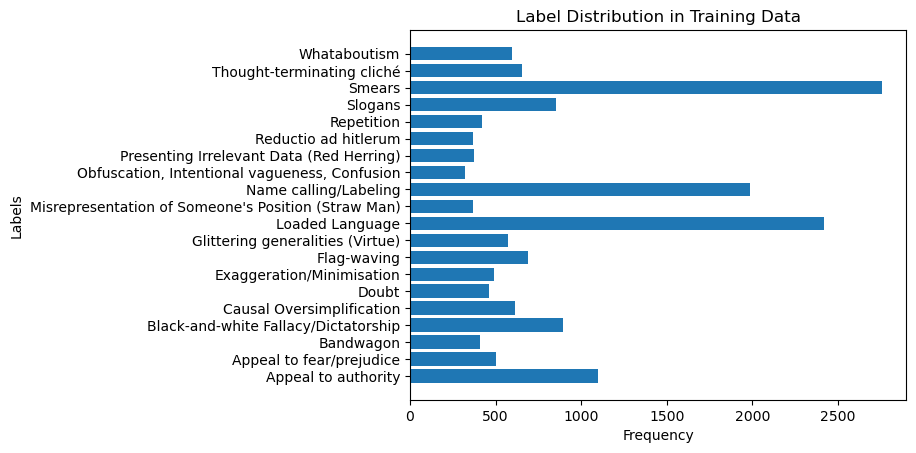

In [6]:
# Fit and transform labels for training data
train_data['encoded_labels'] = mlb.fit_transform(train_data['labels']).tolist()
y_train = np.array(train_data['encoded_labels'].tolist())

# Transform labels for validation data
validation_data['encoded_labels'] = mlb.transform(validation_data['labels']).tolist()
y_val = np.array(validation_data['encoded_labels'].tolist())

# Remove samples with empty labels (optional)
train_data = train_data[train_data['labels'].apply(len) > 0]
validation_data = validation_data[validation_data['labels'].apply(len) > 0]

# Verify label distribution 
label_counts = y_train.sum(axis=0)

# label distribution
plt.barh(mlb.classes_, label_counts)
plt.xlabel("Frequency")
plt.ylabel("Labels")
plt.title("Label Distribution in Training Data")
plt.show()


## Training

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Initialize One-vs-Rest Logistic Regression
lr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight="balanced"))
lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)

# Evaluate the model on the training set
precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_train_pred, average="micro")
accuracy = accuracy_score(y_train, y_train_pred)

print("Training Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Inspect predictions for a few samples
predicted_labels_train = mlb.inverse_transform(y_train_pred)
for idx, text in enumerate(train_data['text'].head(3)):
    print(f"Text: {text}")
    print(f"True Labels: {train_data['labels'].iloc[idx]}")
    print(f"Predicted Labels: {predicted_labels_train[idx]}")
    print("-" * 50)


Training Performance:
Precision: 0.6454
Recall: 0.9103
F1 Score: 0.7553
Accuracy: 0.3758
Text: FREE RAMAN PRATASEVICH\n
True Labels: ['Slogans']
Predicted Labels: ('Repetition', 'Slogans', 'Smears')
--------------------------------------------------
Text: \ALL WE NEED IS THE RIGHT MAJOR CRISIS, AND THE NATIONS WILL ACCEPT THE NEW WORLD ORDER.\\n\n- DAVID ROCKEFELLER
True Labels: ['Appeal to authority', 'Loaded Language', 'Thought-terminating cliché']
Predicted Labels: ('Appeal to authority', 'Black-and-white Fallacy/Dictatorship', 'Thought-terminating cliché')
--------------------------------------------------
Text: NOLTE: POLLING SHOWS MAJORITY BLAME BIDEN FOR\nAFGHANISTAN, TRUMP WOULD WIN RE-VOTE\n
True Labels: ['Doubt', 'Bandwagon', 'Thought-terminating cliché']
Predicted Labels: ('Bandwagon', 'Doubt', 'Thought-terminating cliché')
--------------------------------------------------


### 6. Validation: 

In [9]:
# Retrain the logistic regression model if needed (only if C or other params are adjusted)
lr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight="balanced", C=0.1))
lr_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = lr_model.predict(X_val)

# Evaluate the validation performance
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average="micro")
accuracy = accuracy_score(y_val, y_val_pred)

# Output performance
print("Validation Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")


Validation Performance:
Precision: 0.3148
Recall: 0.3762
F1 Score: 0.3428
Accuracy: 0.0073


In [12]:
# Load pretrained embeddings (GloVe embeddings)
import gensim.downloader as api
from sklearn.preprocessing import normalize


embedding_model = api.load("glove-wiki-gigaword-50")  

def text_to_embedding(text, embedding_model, vector_size=50):
    """Convert text to an average word embedding."""
    words = text.split()
    embeddings = [embedding_model[word] for word in words if word in embedding_model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

# Generate word embeddings for training and validation
X_train_embeddings = np.array([text_to_embedding(text, embedding_model) for text in train_data['cleaned_text']])
X_val_embeddings = np.array([text_to_embedding(text, embedding_model) for text in validation_data['cleaned_text']])

# Combine TF-IDF features and word embeddings
X_train_combined = np.hstack([normalize(X_train.toarray()), normalize(X_train_embeddings)])
X_val_combined = np.hstack([normalize(X_val.toarray()), normalize(X_val_embeddings)])

# Train Logistic Regression on combined features
lr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight="balanced", C=1))
lr_model.fit(X_train_combined, y_train)

# Predict and Evaluate on Validation Set
y_val_pred = lr_model.predict(X_val_combined)

precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average="micro")
accuracy = accuracy_score(y_val, y_val_pred)

print("Validation Performance with Combined Features:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Validation Performance with Combined Features:
Precision: 0.3054
Recall: 0.4088
F1 Score: 0.3496
Accuracy: 0.0170


# Advanced Models: DeBERTa Multilabel Classification

In [8]:
#!pip install transformers datasets

In [9]:
#import torch

#device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
#print(f"Using device: {device}")
#model.to(device)


In [7]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to binary predictions using a threshold of 0.5
    predictions = (logits.sigmoid().numpy() > 0.5).astype(int)

    # Compute metrics 
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='micro')

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [11]:
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.preprocessing import MultiLabelBinarizer
import torch
from torch.utils.data import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import scipy.special

# Initialize RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Function to tokenize text data
def tokenize_function(texts, max_length=128):
    return tokenizer(
        texts,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )

# Prepare tokenized datasets
train_texts = train_data["cleaned_text"].tolist()
train_labels = train_data["labels"]
validation_texts = validation_data["cleaned_text"].tolist()
validation_labels = validation_data["labels"]

# Encode labels using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_labels)
y_val = mlb.transform(validation_labels)

# Tokenize text data for training and validation
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(validation_texts)

# Define a custom dataset for multi-label classification
class MultilabelDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

# Create datasets
train_dataset = MultilabelDataset(train_encodings, y_train)
val_dataset = MultilabelDataset(val_encodings, y_val)

# Load RoBERTa model for multilabel classification
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(mlb.classes_),
    problem_type="multi_label_classification"
)

training_args = TrainingArguments(
    output_dir="./roberta_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,   
    num_train_epochs=10,            
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=500,              
    save_steps=500,                 
    save_total_limit=2,             
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=False                      
)


# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (scipy.special.expit(logits) > 0.5).astype(int)
    return {
        'precision': precision_score(labels, predictions, average='micro'),
        'recall': recall_score(labels, predictions, average='micro'),
        'f1_score': f1_score(labels, predictions, average='micro'),
        'accuracy': accuracy_score(labels, predictions)
    }

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
evaluation_results = trainer.evaluate()
print("Evaluation Results:", evaluation_results)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/niloofarkarimi/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/q0/54d0yrqj2dz0f0nfww0g5x1r0000gn/T/ipykernel_7663/213374786.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Score,Accuracy
1,0.317300,0.314926,0.583959,0.166037,0.258558,0.018715
2,0.235000,0.302404,0.704087,0.227927,0.344373,0.030880
3,0.185600,0.306068,0.626547,0.280915,0.387909,0.043980
4,0.144500,0.318173,0.609820,0.324878,0.423917,0.048659
5,0.116400,0.332078,0.606947,0.337744,0.433989,0.065814
6,0.092100,0.346701,0.605662,0.356159,0.448549,0.060667
7,0.075000,0.361669,0.604933,0.352927,0.445779,0.068465
8,0.063000,0.369706,0.592533,0.402561,0.479413,0.070493
9,0.052500,0.383327,0.601412,0.384390,0.469013,0.074080
10,0.046600,0.386543,0.589976,0.392622,0.471480,0.076263


/var/folders/q0/54d0yrqj2dz0f0nfww0g5x1r0000gn/T/ipykernel_7663/213374786.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/q0/54d0yrqj2dz0f0nfww0g5x1r0000gn/T/ipykernel_7663/213374786.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/var/folders/q0/54d0yrqj2dz0f0nfww0g5x1r0000gn/T/ipykernel_7663/213374786.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key

Evaluation Results: {'eval_loss': 0.3024035096168518, 'eval_precision': 0.704087398756828, 'eval_recall': 0.2279268292682927, 'eval_f1_score': 0.34437330139573447, 'eval_accuracy': 0.030879600748596383, 'eval_runtime': 93.6926, 'eval_samples_per_second': 68.437, 'eval_steps_per_second': 8.56, 'epoch': 10.0}
